In [ ]:
!git clone https://github.com/icomse/5th_workshop_MachineLearning.git
import os
os.chdir('5th_workshop_MachineLearning/data')
data_dir = os.getcwd()

Cloning into '5th_workshop_MachineLearning'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 82 (delta 26), reused 46 (delta 12), pack-reused 0
Unpacking objects: 100% (82/82), 8.05 MiB | 9.66 MiB/s, done.


# Make sure you can see the files we'll need

In [ ]:
os.listdir(data_dir)

['perovskite_data.csv',
 'nomad',
 'DES_SurfaceTension.xlsx',
 'stockholm_td_adj.dat',
 'configs',
 'linmod.csv',
 'HCEPDB_100K_cleaned.csv']

# Import the python modules we'll use and configure matplotlib



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

plt.style.use(os.path.join(data_dir, 'configs', 'plot_style.mplstyle'))

# load the data from the ["New Tolerance Factor" paper](https://www.science.org/doi/10.1126/sciadv.aav0693)

In [ ]:
fcsv = os.path.join(data_dir, 'perovskite_data.csv')
df = pd.read_csv(fcsv)
df.head()

,ABX3,exp_label,is_train,A,B,X,nA,nB,nX,rA (Ang),rB (Ang),rX (Ang),t,tau,t_pred,tau_pred,tau_prob
0,AgBrO3,-1.0,1,Ag,Br,O,1,5,-2,1.28,0.31,1.40,1.11,6.43,-1,-1,0.05
1,AgCdBr3,-1.0,1,Ag,Cd,Br,1,2,-1,1.28,0.95,1.96,0.79,5.58,-1,-1,0.12
2,PbAgBr3,-1.0,1,Pb,Ag,Br,2,1,-1,1.49,1.15,1.96,0.78,7.71,-1,-1,0.01
3,AgCaCl3,-1.0,1,Ag,Ca,Cl,1,2,-1,1.28,1.00,1.81,0.78,6.00,-1,-1,0.07
4,AgClO3,-1.0,1,Ag,Cl,O,1,5,-2,1.28,0.12,1.40,1.25,15.17,-1,-1,0.00


# Consider a new feature called the "octahedral factor" (mu = rB/rX)

In [ ]:
df['mu'] = df['rB (Ang)'] / df['rX (Ang)']
df.head()

,ABX3,exp_label,is_train,A,B,X,nA,nB,nX,rA (Ang),rB (Ang),rX (Ang),t,tau,t_pred,tau_pred,tau_prob,mu
0,AgBrO3,-1.0,1,Ag,Br,O,1,5,-2,1.28,0.31,1.40,1.11,6.43,-1,-1,0.05,0.221429
1,AgCdBr3,-1.0,1,Ag,Cd,Br,1,2,-1,1.28,0.95,1.96,0.79,5.58,-1,-1,0.12,0.484694
2,PbAgBr3,-1.0,1,Pb,Ag,Br,2,1,-1,1.49,1.15,1.96,0.78,7.71,-1,-1,0.01,0.586735
3,AgCaCl3,-1.0,1,Ag,Ca,Cl,1,2,-1,1.28,1.00,1.81,0.78,6.00,-1,-1,0.07,0.552486
4,AgClO3,-1.0,1,Ag,Cl,O,1,5,-2,1.28,0.12,1.40,1.25,15.17,-1,-1,0.00,0.085714


# Visualize how perovskites and nonperovskites segment on a 2D map made of Goldschmidt's tolerance factor, t, and the octahedral factor, mu

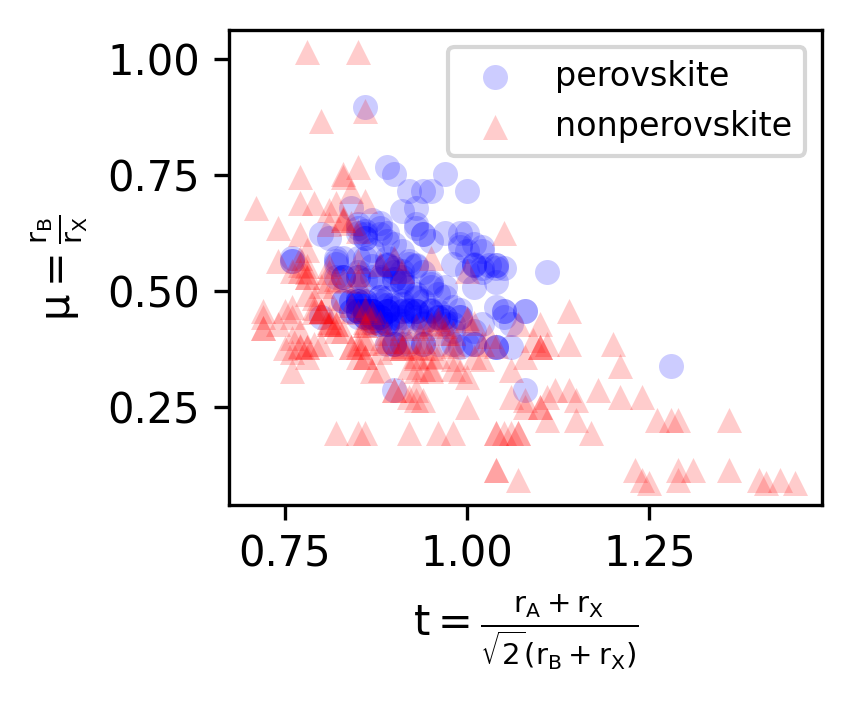

In [ ]:
fig = plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)

# just look at original training set
df_train = df.get(df.is_train == 1)

# plot perovskite (+1) class
t_perov = df_train.t.get((df_train.exp_label == 1)).values
mu_perov = df_train.mu.get((df_train.exp_label == 1)).values
ax = plt.scatter(t_perov, mu_perov, color='blue', alpha=0.2, marker='o', lw=0, label='perovskite')

# plot nonperovskite (-1) class
t_nonperov = df_train.t.get((df_train.exp_label == -1)).values
mu_nonperov = df_train.mu.get((df_train.exp_label == -1)).values
ax = plt.scatter(t_nonperov, mu_nonperov, color='red', alpha=0.2, marker='^', lw=0, label='nonperovskite')

# label
ax = plt.ylabel(r'$\mu=\frac{r_B}{r_X}$')
ax = plt.xlabel(r'$t=\frac{r_A+r_X}{\sqrt{2}(r_B+r_X)}$')
plt.legend()

# **Hands-on**: Which feature (t or mu) is more important for this classification problem?

## Guidelines
- determine (quantitatively) whether t or mu is more valuable in separating perovskites from nonperovskites
- consider a decision tree that can only make two decisions (i.e., two linear decision boundaries are drawn)
- plot the decision boundaries

## Hints
- information gain will be useful
- you might restrict the `max_leaf_nodes`
- decision tree models can be visualized with `sklearn.tree.plot_tree`

In [ ]:
# write your code here

### Alternatively, sklearn nicely does this for us already

In [ ]:
features = ['t', 'mu']
importances = dt.feature_importances_
print(dict(zip(features, importances)))

{'t': 0.41232473920686724, 'mu': 0.5876752607931328}


### Why the difference compared to our numbers?

In [ ]:
our_importances = [IG_t / (IG_mu + IG_t), IG_mu / (IG_mu + IG_t)]
print(dict(zip(features, our_importances)))

{'t': 0.41232473920686735, 'mu': 0.5876752607931326}


### Visualize our learned decision boundary

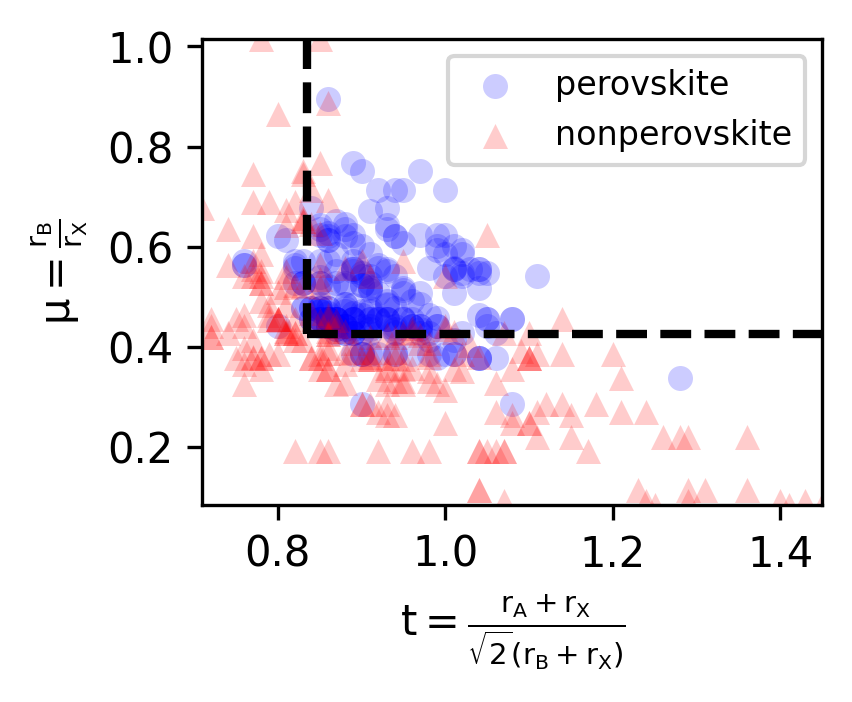

In [ ]:
fig = plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)

# just look at original training set
df_train = df.get(df.is_train == 1)

# plot perovskite (+1) class
t_perov = df_train.t.get((df_train.exp_label == 1)).values
mu_perov = df_train.mu.get((df_train.exp_label == 1)).values
ax = plt.scatter(t_perov, mu_perov, color='blue', alpha=0.2, marker='o', lw=0, label='perovskite')

# plot nonperovskite (-1) class
t_nonperov = df_train.t.get((df_train.exp_label == -1)).values
mu_nonperov = df_train.mu.get((df_train.exp_label == -1)).values
ax = plt.scatter(t_nonperov, mu_nonperov, color='red', alpha=0.2, marker='^', lw=0, label='nonperovskite')

# plot_boundaries
ax = plt.plot([0.835, 1000], [0.427, 0.427], color='black', ls='--')
ax = plt.plot([0.835, 0.835], [0.427, 1000], color='black', ls='--')

# label
ax = plt.ylabel(r'$\mu=\frac{r_B}{r_X}$')
ax = plt.xlabel(r'$t=\frac{r_A+r_X}{\sqrt{2}(r_B+r_X)}$')
ax = plt.ylim([df.mu.min(), df.mu.max()])
ax = plt.xlim([df.t.min(), df.t.max()])

plt.legend()

### Would the information gain have been the same if t made the first split instead of mu?

# Now, lets consider importances for an ensemble of decision trees (random forest)

## This time, we'll use the ionic features (oxidation states and radii)

In [ ]:
ions = ['A', 'B', 'X']
df = df.rename(columns={'r%s (Ang)' % v : 'r%s' % v for v in ions})
df_train = df.get((df.is_train == 1))
features = ['n%s' % ion for ion in ions] + ['r%s' % ion for ion in ions]


In [ ]:
features

['nA', 'nB', 'nX', 'rA', 'rB', 'rX']

# Fit a generic random forest to these features (again predicting perovskite vs nonperovskite)

In [ ]:
rf = RandomForestClassifier(random_state=44)

X_train, y_train = df_train[features].values, df_train['exp_label'].values
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=44)

# Use sklearn to compute the information gain over this forest of decision trees

In [ ]:
rf_importances = rf.feature_importances_
print(features)
print(rf_importances)

['nA', 'nB', 'nX', 'rA', 'rB', 'rX']
[0.10751281 0.06349688 0.01603049 0.27927925 0.38836561 0.14531496]


# Let's visualize these

In [ ]:
def plot_importances(features_and_their_importances, ylabel='importance'):
    """
    Args:
        features_and_their_importances (dict):
            {feature (str) : importance (float)}
    Returns:
        matplotlib bar chart of sorted importances
    """
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'

    n_features = len(features_and_their_importances)
    sorted_features = sorted(features_and_their_importances,
                             key=features_and_their_importances.get,
                             reverse=True)
    sorted_importances = [features_and_their_importances[f] for f in sorted_features]

    ax = plt.bar(range(n_features), sorted_importances,
                 color=bar_color, align=align, label=label)
    ax = plt.xticks(range(n_features), sorted_features, rotation=90)
    ax = plt.xlim([-1, n_features])
    ax = plt.ylabel(ylabel, fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width,
                         which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

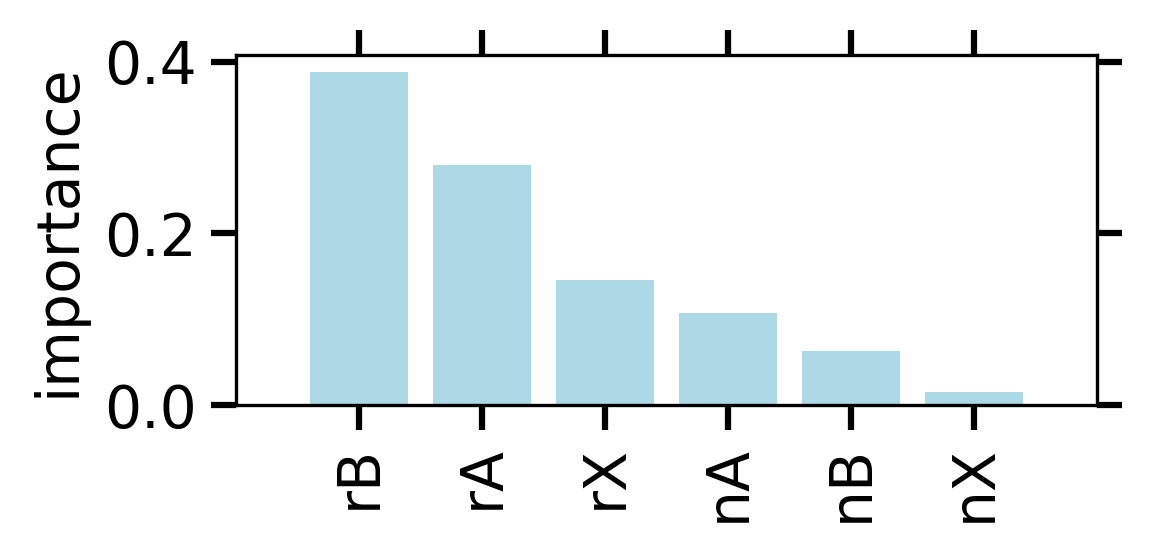

In [ ]:
features_and_their_importances = dict(zip(features, rf_importances))

fig = plt.figure()
ax = plt.subplot(111)
ax = plot_importances(features_and_their_importances)

# **Hands-on**: Are these reliable??

## Guidelines:
- include a random variable among your features and repeat this process
- train, compute importances, plot

In [ ]:
# write your code here

# Let's discuss another way to compute importances

# OK, now let's give permutation importances a try

In [ ]:
pm_importances = permutation_importance(rf2, X_train, y_train, random_state=44)['importances_mean']

In [ ]:
features_to_pm_importances = dict(zip(features, pm_importances))

In [ ]:
fig = plt.figure(figsize=(5,2.5))
ax = plt.subplot(111)
ax = plot_importances(features_to_pm_importances)

# Looks better, but still makes me a bit uncomfortable!
- what is this telling us?
- what's something else we can try?

In [ ]:
X_test = df[features].get(df.is_train == -1).values
y_test = df['exp_label'].get(df.is_train == -1).values

pm_importances_test = permutation_importance(rf2, X_test, y_test, random_state=44, n_repeats=5)['importances_mean']
features_to_pm_importances_test = dict(zip(features, pm_importances_test))

In [ ]:
fig = plt.figure(figsize=(5,2.5))
ax = plt.subplot(111)
ax = plot_importances(features_to_pm_importances_test)